### 안녕하세요, 딥러닝을 학습하시면서 모두 MNIST는 잘 하실 것 같고, 저도 딥러닝 공부를 하다 XAI 관련하여 도움을 드릴 수 있을까 하여 글을 적어봤습니다.

### 정말 간단하게 XAI 사용방법에 대하여 작성하였으며, XAI 관련하여 처음 접하시는 분들에게 많은 도움이 될 것 같습니다.

### XAI 기법 중 (Saliency maps, integrated gradient, smooth-Saliency map, smooth-integrated gradient) 사용 방법을 작성하였으며 , IG(Integrated gradient로 해봤는데, <span style="color:red"> 기대 이상으로 성능이 좋네요. </span>

#### <span style="color:red"> XAI란? </span> 설명가능한 인공지능(eXplainable AI, XAI)로 인공지능 모델이 내린 판단을 사람이 이해할 수 있도록 분석을 통해 설명하는 방법입니다.

#### 아래 그림을 예시로 들면, 강아지 이미지가 있다고 할때, XAI 기법을 이용해서 해당 영역이 강아지라는 분류에 큰 영향을 미쳤다고 설명이 될 수 있습니다.

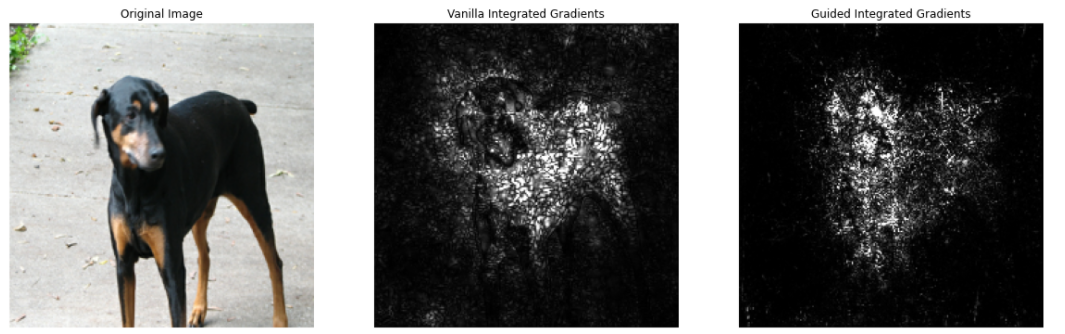

In [1]:
# 출처: https://github.com/PAIR-code/saliency
from IPython.display import Image
Image('xai_image.PNG')

#### XAI 관련한 정보는 아래 링크에 들어가시면 많은 도움이 되실 것 같습니다.

1. [XAI 활용 방법 github](https://github.com/PAIR-code/saliency)
2. [XAI survey 국내 논문, 설명가능한 인공지능을 위한 특성기여도 분석 방법론 조사 paper](https://www.dbpia.co.kr/Journal/articleDetail?nodeId=NODE10501409)
3. [Saliency maps paper](https://arxiv.org/abs/1312.6034)
4. [Integrated gradient](https://arxiv.org/abs/1703.01365)

### 아래 코드 관련하여 대략적인 순서는 다음과 같습니다.

1. XAI 데이터 추출을 하기 위해서, 사전 학습된 딥러닝 모델
2. 원본 데이터를 XAI 데이터로 추출
3. 추출된 XAI 데이터를 활용하여, 딥러닝 모델 분류 학습

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import pandas as pd
import warnings
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import trange

import warnings
warnings.filterwarnings("ignore")

np.random.seed(0)

## 데이터셋 로드

In [3]:
train_df = pd.read_csv('./dataset/train/train_data.csv')
test_df = pd.read_csv('./dataset/test/test_data.csv')
submission_csv = pd.read_csv('./dataset/sample_submission.csv')

In [4]:
train_file_dir = 'dataset/train/'
test_file_dir = 'dataset/test/'

# 데이터 저장할 공간 생성
x_train = np.zeros((len(train_df), 28, 28, 1))
y_train = train_df['label']

x_test = np.zeros((len(test_df), 28, 28, 1))

for i, image_name in enumerate(train_df['filen_name']):
    
    x_train[i] = np.reshape(np.array(Image.open(train_file_dir + image_name)), (28, 28, 1))

for i, image_name in enumerate(test_df['file_name']):
    
    x_test[i] = np.reshape(np.array(Image.open(test_file_dir + image_name)), (28, 28, 1))

In [5]:
# 데이터 분할
from sklearn.model_selection import train_test_split

X_train, X_validation, Y_train, Y_validation = train_test_split(x_train, y_train, test_size=0.1, shuffle=True)

In [6]:
# XAI를 수행하기 위해 사전 딥러닝 모델을 학습

from tensorflow.keras import Model, Sequential
from tensorflow.keras import layers

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model = Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 1)),
    layers.MaxPool2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPool2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

model.fit(X_train, Y_train, epochs=20, shuffle=True, validation_data=(X_validation, Y_validation))

model.trainable = False

Epoch 1/20
141/141 [==============================] - 4s 8ms/step - loss: 1.2141 - accuracy: 0.7829 - val_loss: 0.2156 - val_accuracy: 0.9220
Epoch 2/20
141/141 [==============================] - 1s 7ms/step - loss: 0.1025 - accuracy: 0.9689 - val_loss: 0.0955 - val_accuracy: 0.9640
Epoch 3/20
141/141 [==============================] - 1s 6ms/step - loss: 0.0335 - accuracy: 0.9896 - val_loss: 0.1355 - val_accuracy: 0.9620
Epoch 4/20
141/141 [==============================] - 1s 6ms/step - loss: 0.0226 - accuracy: 0.9922 - val_loss: 0.1091 - val_accuracy: 0.9760
Epoch 5/20
141/141 [==============================] - 1s 6ms/step - loss: 0.0317 - accuracy: 0.9909 - val_loss: 0.1132 - val_accuracy: 0.9660
Epoch 6/20
141/141 [==============================] - 1s 7ms/step - loss: 0.0299 - accuracy: 0.9887 - val_loss: 0.0830 - val_accuracy: 0.9720
Epoch 7/20
141/141 [==============================] - 1s 9ms/step - loss: 0.0203 - accuracy: 0.9918 - val_loss: 0.1494 - val_accuracy: 0.9720
Epoch 

## XAI 데이터 추출

In [7]:
# 원본 데이터를 XAI 데이터로 추출
# [링크]의 코드를 가져왔으며, 간단한 주석으로 설명을 대체합니다.

import saliency.core as saliency

def model_fn(images, call_model_args, expected_keys=None):
    """
    인공지능 모델의 output과 input 사이의 gradient 연산 처리    
    """

    target_class_idx = call_model_args['class']
    model = call_model_args['model']
    images = tf.convert_to_tensor(images)

    with tf.GradientTape() as tape:
        if expected_keys==[saliency.base.INPUT_OUTPUT_GRADIENTS]:
            tape.watch(images)
            output = model(images)
            output = output[:,target_class_idx]
            gradients = np.array(tape.gradient(output, images))
            return {saliency.base.INPUT_OUTPUT_GRADIENTS: gradients}
        else:
            conv, output = model(images)
            gradients = np.array(tape.gradient(output, conv))
            return {saliency.base.CONVOLUTION_LAYER_VALUES: conv,
                    saliency.base.CONVOLUTION_OUTPUT_GRADIENTS: gradients}

### XAI 기법 중 4가지 방법을 작성하였으며, 해당 코드는 ig로 수행하였습니다.

In [8]:
def vanilla_saliency(model, img):
    """
    Saliency map을 이용하여 기여도 맵 추출 함수

    :model: 학습된 인공지능 모델
            인공지능 모델이 바뀔 때, 기여도 맵 또한 변경됨.
    :img:   기여도 맵을 추출하고 하는 이미지 데이터
    :return: 추출된 기여도 맵

    """
    pred = model(np.array([img]))
    pred_cls = np.argmax(pred[0])
    args = {'model': model, 'class': pred_cls}

    grad = saliency.GradientSaliency()
    attr = grad.GetMask(img, model_fn, args)
    attr = saliency.VisualizeImageGrayscale(attr)
    
    return tf.reshape(attr, (*attr.shape, 1))

def ig(model, img):
    pred = model(np.array([img]))
    pred_cls = np.argmax(pred[0])
    args = {'model': model, 'class': pred_cls}

    baseline = np.zeros(img.shape)
    ig = saliency.IntegratedGradients()
    attr = ig.GetMask(img, model_fn, args, x_steps=25, x_baseline=baseline, batch_size=20)
    attr = saliency.VisualizeImageGrayscale(attr)

    return tf.reshape(attr, (*attr.shape, 1))

def smooth_saliency(model, img):
    pred = model(np.array([img]))
    pred_cls = np.argmax(pred[0])
    args = {'model': model, 'class': pred_cls}

    smooth_grad = saliency.GradientSaliency()
    smooth_attr = smooth_grad.GetSmoothedMask(img, model_fn, args)
    smooth_attr = saliency.VisualizeImageGrayscale(smooth_attr)

    return tf.reshape(smooth_attr, (*smooth_attr.shape, 1))

def smooth_ig(model, img):

    pred = model(np.array([img]))
    pred_cls = np.argmax(pred[0])
    args = {'model': model, 'class': pred_cls}

    baseline = np.zeros(img.shape)
    smooth_ig = saliency.IntegratedGradients()

    smooth_attr = smooth_ig.GetSmoothedMask(
        img, model_fn, args, x_steps=25, x_baseline=baseline, batch_size=20)

    smooth_attr = saliency.VisualizeImageGrayscale(smooth_attr)

    return tf.reshape(smooth_attr, (*smooth_attr.shape, 1))

### sample 데이터 확인
### saliency map 같은 경우, 설명되는 영역이 자세하지 않지만, IG의 경우 뚜렷한 것을 볼 수 있습니다.

In [9]:
data_num = 77

sample_image = X_validation[data_num]
sample_saliency_xai_image = vanilla_saliency(model, X_validation[data_num])
sample_ig_xai_image = ig(model, X_validation[data_num])

(-0.5, 27.5, 27.5, -0.5)

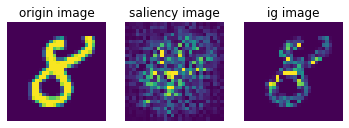

In [10]:
plt.subplot(1, 3, 1)
plt.imshow(np.reshape(sample_image, (28, 28)))
plt.title("origin image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(np.reshape(sample_saliency_xai_image, (28, 28)))
plt.title("saliency image")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(np.reshape(sample_ig_xai_image, (28, 28)))
plt.title("ig image")
plt.axis('off')

### XAI 형태로 데이터 추출

In [11]:
ig_x_train = np.zeros_like(x_train)
ig_x_test = np.zeros_like(x_test)

for i in trange(len(ig_x_test)):
    
    ig_x_train[i] = ig(model, x_train[i])
    ig_x_test[i] = ig(model, x_test[i])


100%|██████████| 5000/5000 [02:25<00:00, 34.32it/s]


### 추출된 XAI 데이터를 가지고, 분류 모델 학습

In [12]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

new_model = Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 1)),
    layers.MaxPool2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPool2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

new_model.compile(optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

new_model.fit(ig_x_train, y_train, epochs=20, shuffle=True)


Epoch 1/20
157/157 [==============================] - 1s 7ms/step - loss: 0.7203 - accuracy: 0.7646
Epoch 2/20
157/157 [==============================] - 1s 6ms/step - loss: 0.1505 - accuracy: 0.9540
Epoch 3/20
157/157 [==============================] - 1s 6ms/step - loss: 0.0829 - accuracy: 0.9762
Epoch 4/20
157/157 [==============================] - 1s 6ms/step - loss: 0.0548 - accuracy: 0.9820
Epoch 5/20
157/157 [==============================] - 1s 6ms/step - loss: 0.0478 - accuracy: 0.9850
Epoch 6/20
157/157 [==============================] - 1s 6ms/step - loss: 0.0216 - accuracy: 0.9938
Epoch 7/20
157/157 [==============================] - 1s 6ms/step - loss: 0.0191 - accuracy: 0.9932
Epoch 8/20
157/157 [==============================] - 1s 6ms/step - loss: 0.0125 - accuracy: 0.9958
Epoch 9/20
157/157 [==============================] - 1s 6ms/step - loss: 0.0115 - accuracy: 0.9966
Epoch 10/20
157/157 [==============================] - 1s 6ms/step - loss: 0.0121 - accuracy: 0.9960

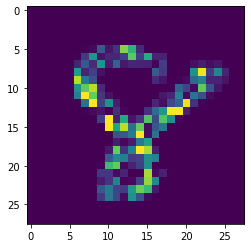

In [20]:
plt.imshow(ig_x_test[100])

  0%|          | 14/5000 [00:14<1:26:20,  1.04s/it]


KeyboardInterrupt: 

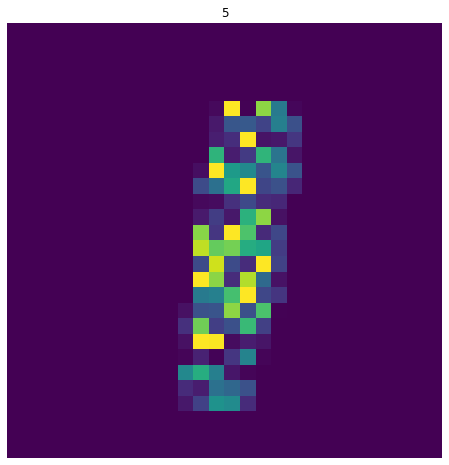

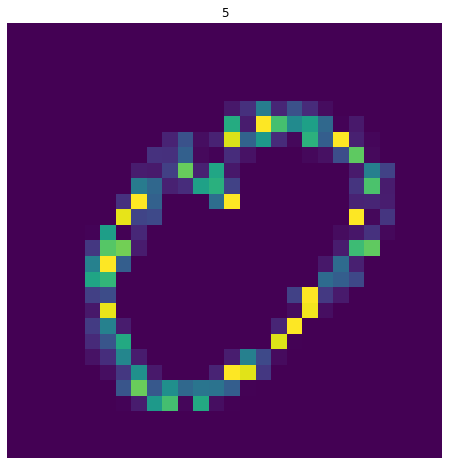

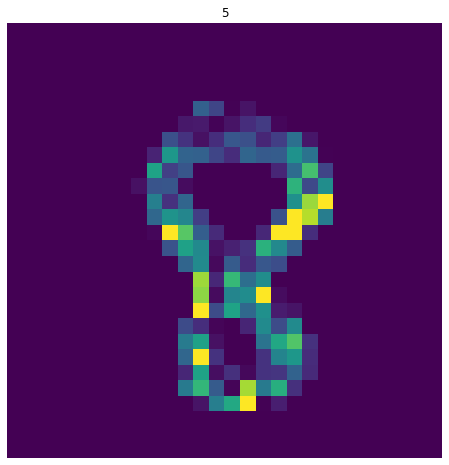

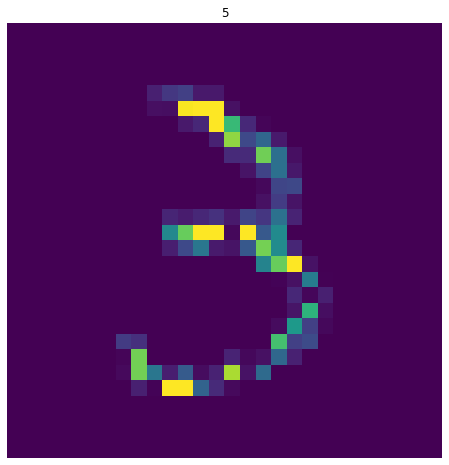

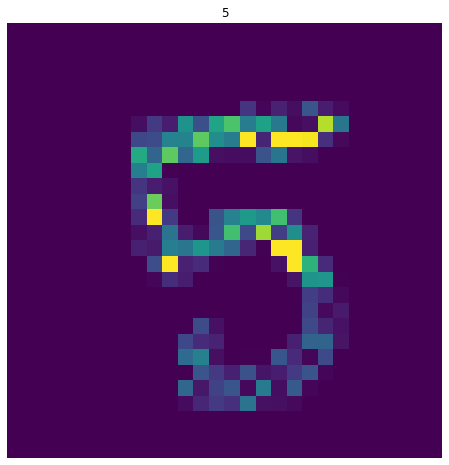

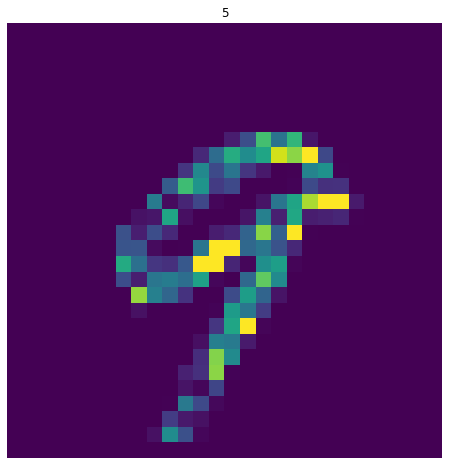

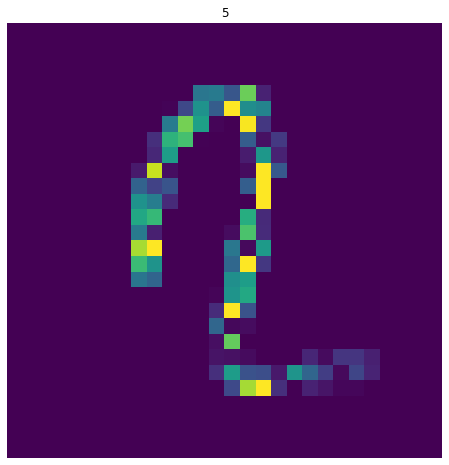

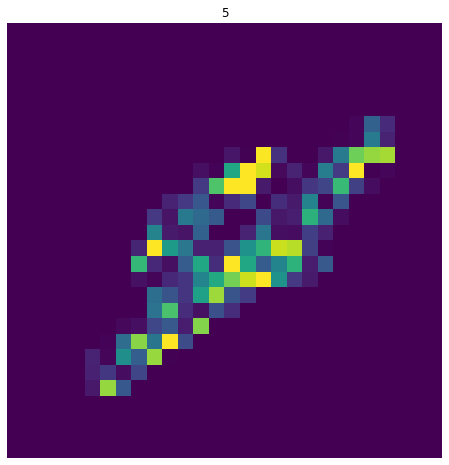

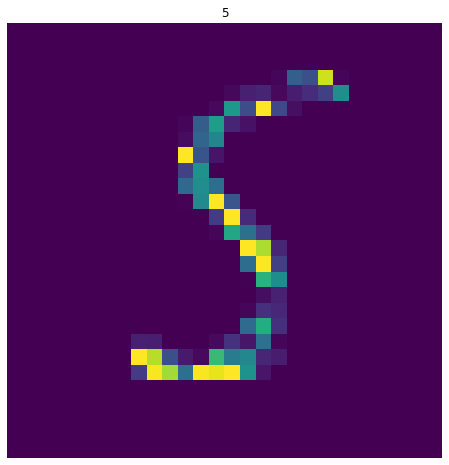

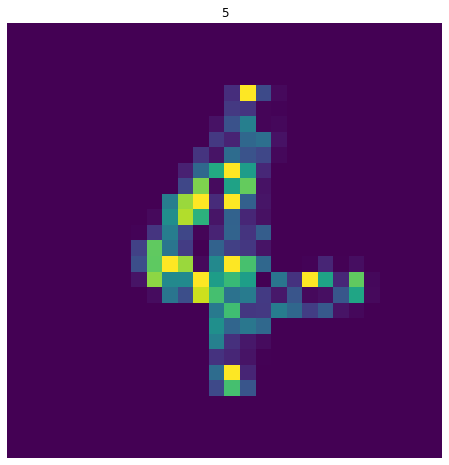

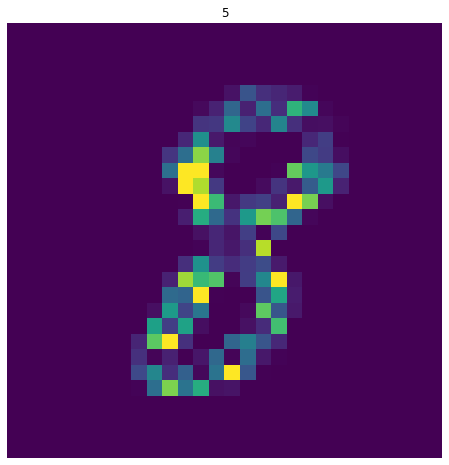

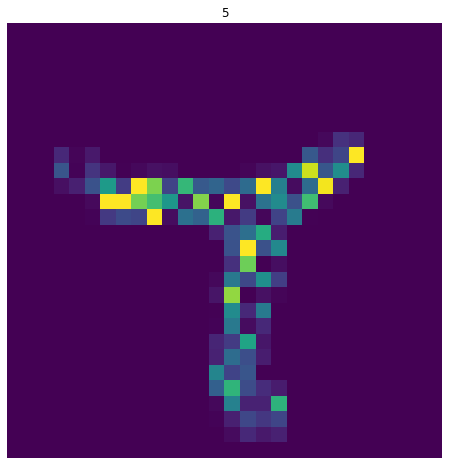

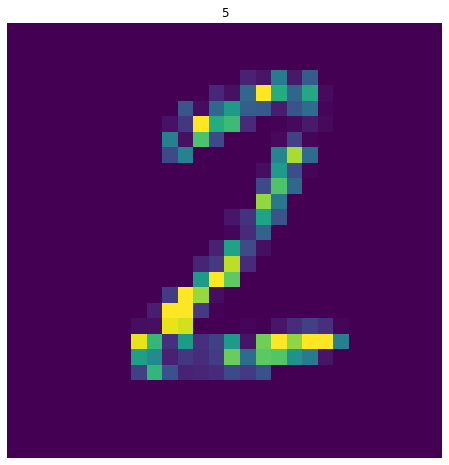

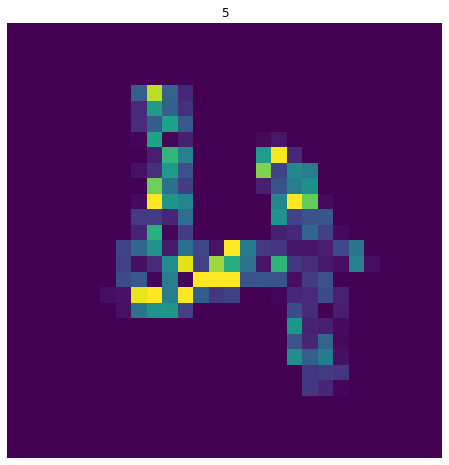

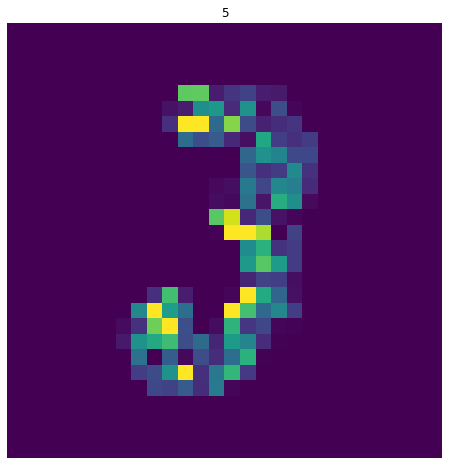

In [23]:
import time

for i in trange(len(ig_x_test)):
#     data = np.expand_dims(ig_x_test[i], 0)
#     pred = new_model.predict(data)
#     pred = np.argmax(pred)

#     plt.imshow(ig_x_test[i])
#     plt.title(pred)
    
    fig, axs = plt.subplots(nrows=1, ncols=1, squeeze=False, figsize=(8, 8))

    axs[0, 0].imshow(ig_x_test[i])
    axs[0, 0].set_title(pred)
    axs[0, 0].axis('off')
    time.sleep(1)


In [14]:
submission_csv.to_csv('submission.csv', index=False)

In [15]:
submission_csv

,file_name,label
0,idx0001.png,1
1,idx0002.png,0
2,idx0003.png,8
3,idx0004.png,3
4,idx0005.png,5
...,...,...
4995,idx4996.png,9
4996,idx4997.png,9
4997,idx4998.png,3
4998,idx4999.png,9
